# Binary Classifications Embeddings Model (AboutText)

Embeddings model for binary classification using the About Text column.

This notebook contains the following sections:<br>
-Data Cleaning<br>
-Creating Metacritic Binary Variable<br>
-Embeddings model + experiments
-Evaluation

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import re

# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout
import tensorflow_datasets as tfds

# shap
import shap

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# others
!pip install wordcloud
import re
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


random.seed(2)
%matplotlib inline

2023-04-13 13:02:42.645699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/amandamurray/opt/anaconda3/envs/w207_final/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading and Cleaning Data

In [2]:
df_raw = pd.read_csv('games-features.csv')

In [3]:
df_raw.head()

,QueryID,ResponseID,QueryName,ResponseName,ReleaseDate,RequiredAge,DemoCount,DeveloperCount,DLCCount,Metacritic,...,LegalNotice,Reviews,SupportedLanguages,Website,PCMinReqsText,PCRecReqsText,LinuxMinReqsText,LinuxRecReqsText,MacMinReqsText,MacRecReqsText
0,10,10,Counter-Strike,Counter-Strike,Nov 1 2000,0,0,1,0,88,...,,,English French German Italian Spanish Simplifi...,None,Minimum: 500 mhz processor 96mb ram 16mb video...,,Minimum: Linux Ubuntu 12.04 Dual-core from Int...,,Minimum: OS X Snow Leopard 10.6.3 1GB RAM 4GB...,
1,20,20,Team Fortress Classic,Team Fortress Classic,Apr 1 1999,0,0,1,0,0,...,,,English French German Italian Spanish,None,Minimum: 500 mhz processor 96mb ram 16mb video...,,Minimum: Linux Ubuntu 12.04 Dual-core from Int...,,Minimum: OS X Snow Leopard 10.6.3 1GB RAM 4GB...,
2,30,30,Day of Defeat,Day of Defeat,May 1 2003,0,0,1,0,79,...,,,English French German Italian Spanish,http://www.dayofdefeat.com/,Minimum: 500 mhz processor 96mb ram 16mb video...,,Minimum: Linux Ubuntu 12.04 Dual-core from Int...,,Minimum: OS X Snow Leopard 10.6.3 1GB RAM 4GB...,
3,40,40,Deathmatch Classic,Deathmatch Classic,Jun 1 2001,0,0,1,0,0,...,,,English French German Italian Spanish,None,Minimum: 500 mhz processor 96mb ram 16mb video...,,Minimum: Linux Ubuntu 12.04 Dual-core from Int...,,Minimum: OS X Snow Leopard 10.6.3 1GB RAM 4GB...,
4,50,50,Half-Life: Opposing Force,Half-Life: Opposing Force,Nov 1 1999,0,0,1,0,0,...,,,English French German Korean,None,Minimum: 500 mhz processor 96mb ram 16mb video...,,Minimum: Linux Ubuntu 12.04 Dual-core from Int...,,Minimum: OS X Snow Leopard 10.6.3 1GB RAM 4GB...,


### Selecting rows and columns used for analysis

In [4]:
df_raw.columns

Index(['QueryID', 'ResponseID', 'QueryName', 'ResponseName', 'ReleaseDate',
       'RequiredAge', 'DemoCount', 'DeveloperCount', 'DLCCount', 'Metacritic',
       'MovieCount', 'PackageCount', 'RecommendationCount', 'PublisherCount',
       'ScreenshotCount', 'SteamSpyOwners', 'SteamSpyOwnersVariance',
       'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance',
       'AchievementCount', 'AchievementHighlightedCount', 'ControllerSupport',
       'IsFree', 'FreeVerAvail', 'PurchaseAvail', 'SubscriptionAvail',
       'PlatformWindows', 'PlatformLinux', 'PlatformMac', 'PCReqsHaveMin',
       'PCReqsHaveRec', 'LinuxReqsHaveMin', 'LinuxReqsHaveRec',
       'MacReqsHaveMin', 'MacReqsHaveRec', 'CategorySinglePlayer',
       'CategoryMultiplayer', 'CategoryCoop', 'CategoryMMO',
       'CategoryInAppPurchase', 'CategoryIncludeSrcSDK',
       'CategoryIncludeLevelEditor', 'CategoryVRSupport', 'GenreIsNonGame',
       'GenreIsIndie', 'GenreIsAction', 'GenreIsAdventure', 'GenreIsCasual',
       'G

In [5]:
df_all = df_raw[['QueryName', 'Metacritic',
         #Genre variables
        'GenreIsNonGame', 'GenreIsIndie', 'GenreIsAction', 'GenreIsAdventure', 
         'GenreIsCasual','GenreIsStrategy', 'GenreIsRPG', 'GenreIsSimulation',
       'GenreIsEarlyAccess', 'GenreIsFreeToPlay', 'GenreIsSports', 'GenreIsRacing',
         #Category variables
        'CategorySinglePlayer','CategoryMultiplayer', 'CategoryCoop', 'CategoryMMO',
       'CategoryInAppPurchase', 'CategoryIncludeSrcSDK',
       'CategoryIncludeLevelEditor', 'CategoryVRSupport',
         #Platform variables
        'PlatformWindows', 'PlatformLinux', 'PlatformMac', 'PCReqsHaveMin',
       'PCReqsHaveRec', 'LinuxReqsHaveMin', 'LinuxReqsHaveRec',
       'MacReqsHaveMin', 'MacReqsHaveRec',
         #Additional Info
        'RequiredAge', 'DemoCount', 'DeveloperCount', 'DLCCount',
        'MovieCount', 'PackageCount', 'RecommendationCount', 
        'ScreenshotCount', 'SteamSpyOwners', 'SteamSpyOwnersVariance','SteamSpyPlayersEstimate', 
         'SteamSpyPlayersVariance','AchievementCount', 'ControllerSupport', 'FreeVerAvail', 
         'PurchaseAvail', 'SubscriptionAvail', 'PriceFinal',
         #Variables that need transformation
         'ReleaseDate', 'SupportedLanguages', 
         #Text variables
         'Reviews','DetailedDescrip','AboutText']]

In [6]:
df = df_all[df_all['Metacritic']>0]

### Dropping Duplicates

In [7]:
df = df.drop_duplicates()

In [8]:
df_vc = pd.DataFrame(df['QueryName'].value_counts())
df_vc[df_vc['QueryName']>1]

,QueryName
Sid Meier's Civilization IV: Colonization,2
Monday Night Combat,2
Fallout: New Vegas,2
Darksiders,2
Alpha Protocol,2
Sid Meier's Civilization V,2
Sid Meier's Civilization IV: Beyond the Sword,2
Sid Meier's Civilization IV: Warlords,2
Arma 2,2
Sid Meier's Civilization IV,2


In [9]:
#drop Sid Meier's Civilization IV: Colonization dup 
df=df.drop(965)
#drop Fallout: New Vegas dup
df=df.drop(952)
#drop Sid Meier's Civilization V dup
df=df.drop(1205)
#drop Darksiders dup
df=df.drop(1210)
#drop Sid Meier's Civilization IV dup
df=df.drop(962)
#Drop Monday night combat dup
df=df.drop(1278)
#Drop Sid Meier's Civilization IV: Beyond the Sword dup
df=df.drop(964)
#Drop Sid Meier's Civilization IV: Warlords dup
df=df.drop(963)
#Drop Arma 2 dup
df=df.drop(782)
#Drop Alpha Protocol dup
df=df.drop(961)

# Creating Metacritic Binary Variable

(array([  0.,   0.,   5.,  18.,  67., 209., 517., 814., 536.,  69.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

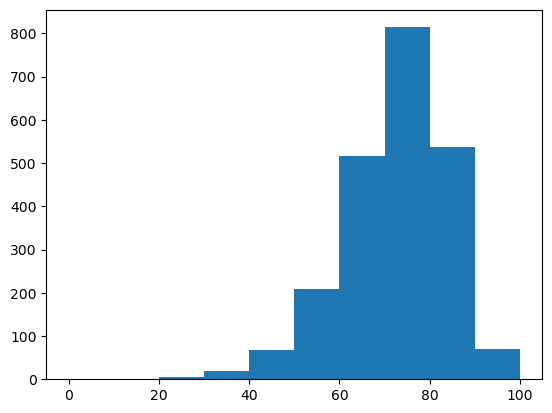

In [24]:
#plot metacritic values
plt.hist(df['Metacritic'], bins=[0,10,20,30,40,50,60,70,80,90,100])

In [25]:
#separate into pos, neg, neutral. Will drop neutral later
conditions = [(df['Metacritic']<=65),
              (df['Metacritic']>65)&(df['Metacritic']<80),
              (df['Metacritic']>=80)
             ]
choices = [0, -1, 1]
df['Metacritic_binary'] = np.select(conditions, choices, default=-1)

(array([1088.,    0.,    0.,    0.,    0.,  542.,    0.,    0.,    0.,
         605.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

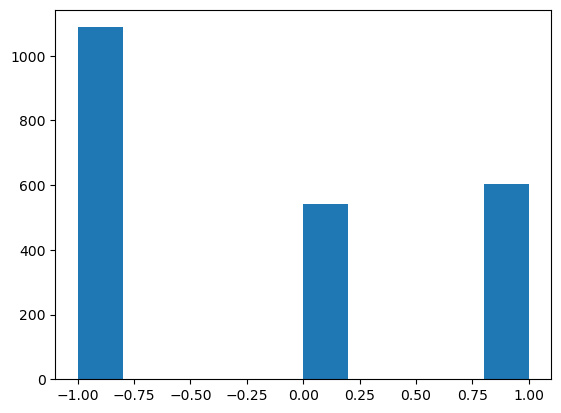

In [26]:
#plot binary values to check for even distribution
plt.hist(df['Metacritic_binary'])

# Embeddings Model

In [27]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

In [28]:
# define function for token encoder
def encode(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    return encoded_text, label

#  wrap the encode function to a TF Operator
def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label], 
                          Tout=(tf.int64, tf.int64))

In [29]:
df_emb = df[['Metacritic_binary', 'AboutText']]

#drop neutral values
df_emb = df_emb[df_emb['Metacritic_binary']>=0]

In [30]:
#apply preprocessor
df_emb['AboutText'] = df_emb['AboutText'].apply(preprocessor)

### create tensorflow dataset

In [31]:
# define target
target = df_emb.pop('Metacritic_binary') # .pop removes sentiment col from df

# target and review combined tensors
data_tf = tf.data.Dataset.from_tensor_slices(
    (df_emb[['AboutText']].values, target.values)
)

In [32]:
# inspection of the first 5 examples
for example in data_tf.take(5):
    # print review (first 40 characters) and sentiment (label)
    tf.print(example[0].numpy()[0][:40], example[1])

b'play the worlds number 1 online action g' 1
b'named game of the year by over 50 public' 1
b'with its extensive tour of duty campaign' 0
b'1998 half life sends a shock through the' 1
b'the next installment of the worlds 1 onl' 1


In [33]:
# set random seed
tf.random.set_seed(1)

# define splits for training, validation, test
splits=[0.6, 0.2, 0.2] 

# shuffle data
data_tf = data_tf.shuffle(
    df_emb.shape[0], reshuffle_each_iteration=False)

data_tf_test = data_tf.take(int(df_emb.shape[0]*splits[2]))
data_tf_train_valid = data_tf.skip(int(df_emb.shape[0]*splits[2]))
data_tf_train = data_tf_train_valid.take(int(df_emb.shape[0]*splits[0]))
data_tf_valid = data_tf_train_valid.skip(int(df_emb.shape[0]*splits[0]))

### Tokens

In [34]:
# try and except the TF tokenizer
try:
    tokenizer = tfds.features.text.Tokenizer()
except AttributeError:
    tokenizer = tfds.deprecated.text.Tokenizer()

# create an instance of the Counter class
token_counts = Counter()

for example in data_tf_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)
    
print('Size of training vocabulary:', len(token_counts))

Size of training vocabulary: 16205


In [48]:
#display tokens
display(token_counts)

Counter({'at': 374,
         'the': 9698,
         'end': 61,
         'of': 5391,
         '19th': 4,
         'century': 19,
         'dark': 163,
         'forces': 100,
         'shade': 1,
         'world': 859,
         'once': 81,
         'again': 42,
         'a': 4069,
         'brave': 14,
         'agent': 31,
         'experienced': 17,
         'in': 2743,
         'exorcism': 1,
         'and': 7260,
         'combat': 317,
         'comes': 53,
         'to': 4785,
         'face': 96,
         'oncoming': 2,
         'evil': 99,
         'fight': 184,
         'loathsome': 1,
         'supernatural': 28,
         'monsters': 82,
         'horrific': 11,
         'spawns': 2,
         'black': 61,
         'magic': 81,
         'role': 84,
         'its': 329,
         'your': 2313,
         'quest': 78,
         'warlock': 1,
         'ancient': 78,
         'times': 35,
         'stop': 45,
         'his': 304,
         'plan': 27,
         'capture': 30,
         'po

In [35]:
# create an instance of the TF encoder class
try:
    encoder = tfds.features.text.TokenTextEncoder(token_counts) # token_counts contains our training vocabulary
except AttributeError:
    encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)

# try an example first (first 12 characters from the second review in training data)
example_str = 'My son took generic for about 6 months.  his his dr actually prescribed prescribed'
encoder.encode(example_str) # the encode method transforms the text into integers

[16206,
 2455,
 7561,
 716,
 104,
 821,
 2323,
 7137,
 42,
 42,
 4315,
 2496,
 16206,
 16206]

In [36]:
data_tf_train = data_tf_train.map(encode_map_fn)
data_tf_valid = data_tf_valid.map(encode_map_fn)
data_tf_test = data_tf_test.map(encode_map_fn)

In [67]:
# define batch size
batch_size = 8

# batcing of training, validation and test partitions
train_data = data_tf_train.padded_batch(
    batch_size,
    padded_shapes=([-1],[]))

valid_data = data_tf_valid.padded_batch(
    batch_size,
    padded_shapes=([-1],[]))

test_data = data_tf_test.padded_batch(
    batch_size,
    padded_shapes=([-1],[]))

Average sequence length in training mini-batches: 504


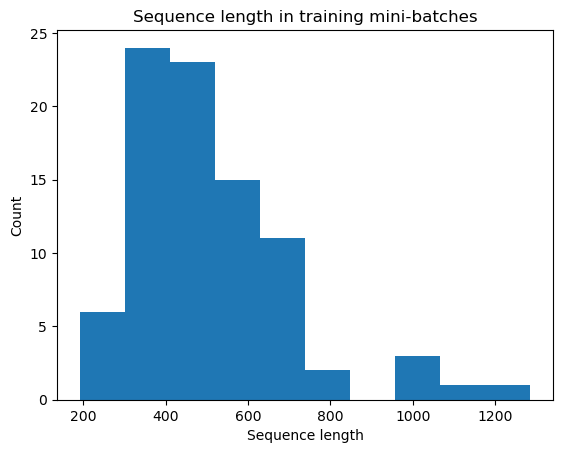

In [68]:
# histogram of sequence length in training mini-batches
seq_len_train = []
for batch in train_data:
    seq_len_train.append(batch[0].shape[1])
    
print('Average sequence length in training mini-batches:',
      int(sum(seq_len_train)/len(seq_len_train))
)

# histogram
plt.hist(seq_len_train)
plt.title('Sequence length in training mini-batches')
plt.ylabel('Count')
plt.xlabel('Sequence length');

## Model

In [153]:
from tensorflow.keras import initializers
vocab_size_train = len(token_counts) + 2
embedding_dim = 8

model = tf.keras.Sequential()
# add embedding layer (this is our imput layer)
# embeddings will be learned during training
# the weights for the embeddings are randomly initialized (just like any other layer!)
model.add(Embedding(
    vocab_size_train,
    embedding_dim,
    embeddings_initializer=initializers.RandomNormal(stddev=0.01),
    #input_length=100, #limits length of sentence to 100 tokens
    name="embedding")
    ),


# average over the emedding dimension, so each review is represented by a 1 vector of size embedding_dimension
model.add(GlobalAveragePooling1D()),

#add Dropout for regularization
model.add(Dropout(0.6))

# add a Dense layer of dimension 16
model.add(Dense(8, activation='tanh')),

#add Dropout for regularization
model.add(Dropout(0.6))

# add last layer (binary classification task)
model.add(Dense(1, activation='sigmoid'))


# save embeddings before training 
embeddings_untrained = model.get_layer('embedding').get_weights()[0]

# print model summary
model.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           129656    
                                                                 
 global_average_pooling1d_53  (None, 8)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_217 (Dropout)       (None, 8)                 0         
                                                                 
 dense_175 (Dense)           (None, 8)                 72        
                                                                 
 dropout_218 (Dropout)       (None, 8)                 0         
                                                                 
 dense_176 (Dense)           (None, 1)                 9         
                                                     

In [154]:
initial_learning_rate = 0.01 ## 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000000, #orginally 100000
    decay_rate=0.4, #originally 0.96
    staircase=True)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer =  tf.keras.optimizers.Adam(learning_rate=lr_schedule), #learning_rate=lr_schedule
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [155]:
# set random seed to get reproductible results 
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
tf.random.set_seed(1)
np.random.seed(1)
history = model.fit(
    train_data, 
    batch_size=20,
    validation_data=valid_data, 
    epochs=7)

Epoch 1/7
86/86 [==============================] - 1s 6ms/step - loss: 0.6922 - binary_accuracy: 0.5436 - val_loss: 0.6882 - val_binary_accuracy: 0.5435
Epoch 2/7
86/86 [==============================] - 0s 6ms/step - loss: 0.6855 - binary_accuracy: 0.5567 - val_loss: 0.6825 - val_binary_accuracy: 0.5435
Epoch 3/7
86/86 [==============================] - 0s 5ms/step - loss: 0.6671 - binary_accuracy: 0.6003 - val_loss: 0.6760 - val_binary_accuracy: 0.6000
Epoch 4/7
86/86 [==============================] - 0s 5ms/step - loss: 0.5716 - binary_accuracy: 0.7078 - val_loss: 0.6556 - val_binary_accuracy: 0.6174
Epoch 5/7
86/86 [==============================] - 0s 5ms/step - loss: 0.4289 - binary_accuracy: 0.8241 - val_loss: 0.6501 - val_binary_accuracy: 0.6522
Epoch 6/7
86/86 [==============================] - 0s 5ms/step - loss: 0.3142 - binary_accuracy: 0.8808 - val_loss: 0.6983 - val_binary_accuracy: 0.6435
Epoch 7/7
86/86 [==============================] - 0s 5ms/step - loss: 0.2934 - bi

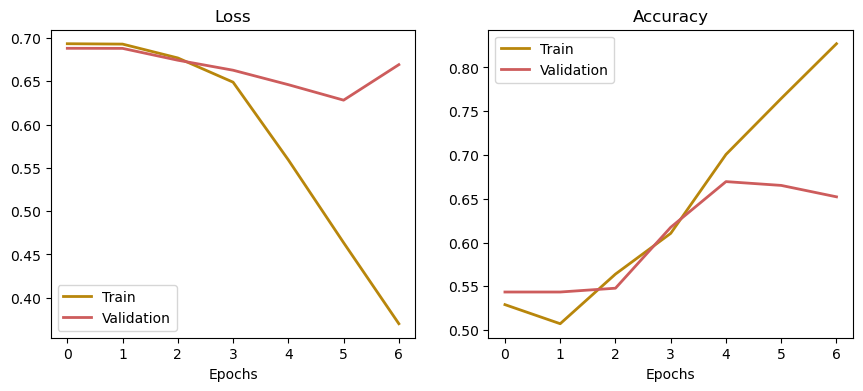

In [72]:
# grab history
history = history.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_binary_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

## Experiments

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           129656    
                                                                 
 global_average_pooling1d_51  (None, 8)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_208 (Dropout)       (None, 8)                 0         
                                                                 
 dense_169 (Dense)           (None, 16)                144       
                                                                 
 dropout_209 (Dropout)       (None, 16)                0         
                                                                 
 dropout_210 (Dropout)       (None, 16)                0         
                                                     

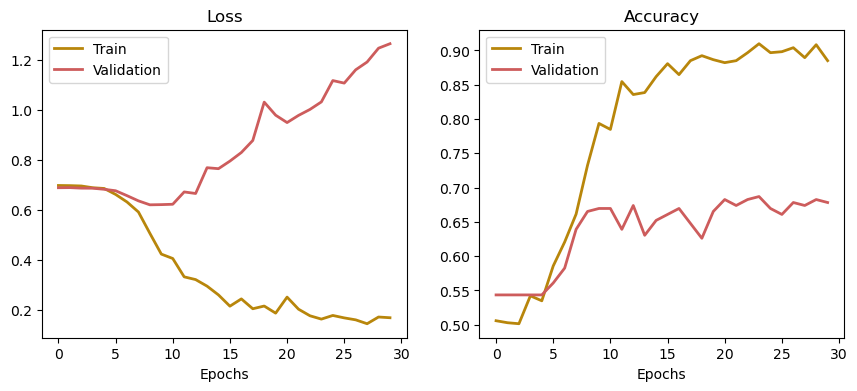

In [149]:
#Experiment with layers
vocab_size_train = len(token_counts) + 2
embedding_dim = 8

model = tf.keras.Sequential()
# add embedding layer (this is our imput layer)
# embeddings will be learned during training
# the weights for the embeddings are randomly initialized (just like any other layer!)
model.add(Embedding(
    vocab_size_train,
    embedding_dim,
    embeddings_initializer=initializers.RandomNormal(stddev=0.01),
    #input_length=100, #limits length of sentence to 100 tokens
    name="embedding")
    ),


#average over the emedding dimension, so each review is represented by a 1 vector of size embedding_dimension
model.add(GlobalAveragePooling1D()),

#add Dropout for regularization
model.add(Dropout(0.6))

# add a Dense layer of dimension 16
model.add(Dense(16, activation='tanh')),

#add Dropout for regularization
model.add(Dropout(0.6))

# add a Dense layer of dimension 16
#model.add(Dense(8, activation='tanh')),

#add Dropout for regularization
#model.add(Dropout(0.3))

# add a Dense layer of dimension 16
#model.add(Dense(4, activation='tanh')),

#add Dropout for regularization
model.add(Dropout(0.5))

model.add(Dropout(0.5))
# add last layer (binary classification task)
model.add(Dense(1, activation='sigmoid'))


# save embeddings before training 
embeddings_untrained = model.get_layer('embedding').get_weights()[0]

# print model summary
model.summary()

initial_learning_rate = 0.005 ## 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000, #orginally 100000
    decay_rate=0.8, #originally 0.96
    staircase=True)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer =  tf.keras.optimizers.Adam(learning_rate=lr_schedule), #learning_rate=lr_schedule
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

tf.random.set_seed(1)
np.random.seed(1)
history = model.fit(
    train_data, 
    batch_size=10,
    validation_data=valid_data, 
    epochs=30)

# grab history
history = history.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_binary_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           129656    
                                                                 
 global_average_pooling1d_52  (None, 8)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_212 (Dropout)       (None, 8)                 0         
                                                                 
 dense_171 (Dense)           (None, 16)                144       
                                                                 
 dropout_213 (Dropout)       (None, 16)                0         
                                                                 
 dense_172 (Dense)           (None, 8)                 136       
                                                     

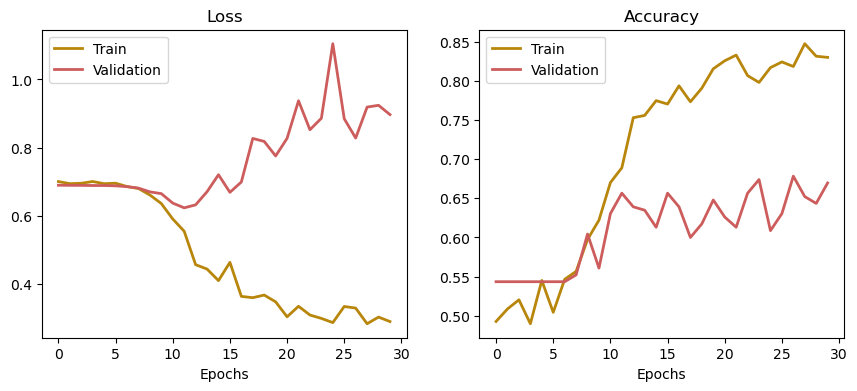

In [151]:
#Experiment with layers
vocab_size_train = len(token_counts) + 2
embedding_dim = 8

model = tf.keras.Sequential()
# add embedding layer (this is our imput layer)
# embeddings will be learned during training
# the weights for the embeddings are randomly initialized (just like any other layer!)
model.add(Embedding(
    vocab_size_train,
    embedding_dim,
    embeddings_initializer=initializers.RandomNormal(stddev=0.01),
    #input_length=100, #limits length of sentence to 100 tokens
    name="embedding")
    ),


#average over the emedding dimension, so each review is represented by a 1 vector of size embedding_dimension
model.add(GlobalAveragePooling1D()),

#add Dropout for regularization
model.add(Dropout(0.6))

# add a Dense layer of dimension 16
model.add(Dense(16, activation='tanh')),

#add Dropout for regularization
model.add(Dropout(0.6))

# add a Dense layer of dimension 16
model.add(Dense(8, activation='tanh')),

#add Dropout for regularization
model.add(Dropout(0.3))

# add a Dense layer of dimension 16
model.add(Dense(4, activation='tanh')),

#add Dropout for regularization
model.add(Dropout(0.5))

model.add(Dropout(0.5))
# add last layer (binary classification task)
model.add(Dense(1, activation='sigmoid'))


# save embeddings before training 
embeddings_untrained = model.get_layer('embedding').get_weights()[0]

# print model summary
model.summary()

initial_learning_rate = 0.005 ## 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000, #orginally 100000
    decay_rate=0.8, #originally 0.96
    staircase=True)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer =  tf.keras.optimizers.Adam(learning_rate=0.003), #learning_rate=lr_schedule
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

tf.random.set_seed(1)
np.random.seed(1)
history = model.fit(
    train_data, 
    batch_size=10,
    validation_data=valid_data, 
    epochs=30)

# grab history
history = history.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_binary_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

EPOCHS | BATCH | LEARNING RATE | EMBEDDINGS SIZE|DROPOUT|LAYERS|TRAIN ACC|VAL ACC
-|-|-|-|-|-|-|-
20|5|0.001|8|0.6|8|0.95|0.67
20|5|0.001|8|0.6|16|0.95|0.67*
20|5|0.001|8|0.6|16,8|0.92|0.69
100|5|0.001|8|0.6,0.8|16,8|0.90|0.66
30|5|0.001|8|0.6,0.4|16,8|0.98|0.69
30|5|0.001|8|0.6,0.4|16,8,8|0.98|0.68
30|5|0.001|8|0.6,0.6,0.3,0.5,0.5|16,8,4|0.81|0.66
30|5|Decaying|8|0.6,0.6,0.3,0.5,0.5|16,8,4|0.83|0.67
30|20|0.005|8|0.6,0.6,0.3,0.5,0.5|16,8,4|0.84|0.66
30|10|0.005|8|0.6,0.6,0.5,0.5|16,8,4|0.83|0.67

# Evaluation

In [152]:
#Evaluate accuracy
test_results = model.evaluate(test_data)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

29/29 [==============================] - 0s 4ms/step - loss: 0.8303 - binary_accuracy: 0.6987

Test Acc. 69.87%


In [44]:
#get true labels
def get_labels_from_tfdataset(tfdataset, batched=False):

    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 

    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels

    return labels

y_test = get_labels_from_tfdataset(test_data, batched=False).numpy()
y_predictions = model.predict(x=test_data).flatten()
y_predictions = np.where(y_predictions>=0.50, 1, 0)

115/115 [==============================] - 0s 1ms/step


In [45]:
#double check accuracy
print('Test, misclassified examples: %d' % (y_test != y_predictions).sum())
error_test_tf = (y_test != y_predictions).sum()/len(y_predictions)
print('Test, prediction accuracy: %.3f'% (1-error_test_tf))

Test, misclassified examples: 75
Test, prediction accuracy: 0.672


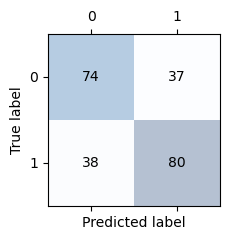

In [46]:
#create confusion matrix
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()
    
conf_matrix = tf.math.confusion_matrix(
    y_test,
    y_predictions,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
confusion_matrix_plot(conf_matrix.numpy())

In [47]:
# show example
predictions = model.predict(test_data)

for ex in test_data.take(1):
    print('Printing encoded example:')
    print('-------------------------')
    print(ex[0].numpy()[0]) # test data is a mini-batch, keep only the first example in the first batch
    
    print('\nPrinting decoded example:')
    print('-------------------------')
    print(encoder.decode(ex[0].numpy()[0]))
    
    print('\nPrinting prediction of example:')
    print('-------------------------------')
    if predictions[0] < 0.5:
        print('Negative metacritic review with probability', predictions[0])
    else:
        print('Positive metacritic review with probability', predictions[0])
        
    print('\nPrinting ground truth of example:')
    print('-----------------------------------')
    ground_truth = ex[1].numpy()[0]
    if ground_truth == 0:
        print('Negative')
    else:
        print('Positive')

115/115 [==============================] - 0s 1ms/step
Printing encoded example:
-------------------------
[14374  5358   929   115   136  1993  1159   233    22  4615  5066  6338
     4 16206  1010    93  1121     2    10   233   130  7721  2194   580
  7579    19 16206  4090    93   483  2555 16206    93  1710 16206    22
  2661  6848   840    22 16206   483  1988   741     4  4906    17    13
   252  4899    19   777    17   124   559  1437  1782     2   156   929
  3034   405  1714     2   649    22     2  2830   297  1942  6606 13097
    93   124  4646    17     2  1641  2183     4   124  2730 11680  1214
    22   349   494   436   268     4    13  1557  2172   659  4492   481
   761     2  3915 14374  5358   929   249  2301    85   617   209   411
    35   477 16206   124   186   780  5340    19  6140  3288    22  1559
    73   133     2   499    79   115   336  4138     4   288     4     2
   331  1862  6388 16206    19 16206   127  1121   617  2111    17  2065
   266   314     